In [1]:
import pandas as pd
import io
import requests
import numpy as np
import random
import libpysal
import pysal
#import pysal.lib
import gpytorch
import torch
import math

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
data = pd.read_csv("grid_aug_housing_knn50.csv")
#Create ID column
data["id"] = np.asarray(list(range(0,len(data["longitude"])))).reshape(-1,1)

In [3]:
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,...,lon_group1,lon_group2,lon_group3,lon_group4,lon_group5,lat_group1,lat_group2,lat_group3,lat_group4,lat_group5
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,...,2,1,2,2,2,2,2,1,2,2
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,...,2,1,2,2,2,2,2,1,2,2
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,...,2,1,2,2,2,2,2,1,2,2


In [4]:
data_drop = data.head(18713) #Last column is broken!
data.drop(data_drop.tail(1).index,inplace=True)
data.drop(columns=["ocean_proximity"])
data = data[np.isfinite(data["total_bedrooms"])]
data = data[np.isfinite(data["total_rooms"])]
data = data[np.isfinite(data["housing_median_age"])]
data = data[np.isfinite(data["population"])]
data = data[np.isfinite(data["households"])]
data = data[np.isfinite(data["median_income"])]
data = data[np.isfinite(data["median_house_value"])]
data.shape

(20432, 24)

In [9]:
#data.to_csv("test.csv")
#data = data.head(100)
m1 = np.mean(data["longitude"])
m2 = np.mean(data["latitude"])
mean = [m1,m2]
cov = np.cov(data["longitude"],data["latitude"])

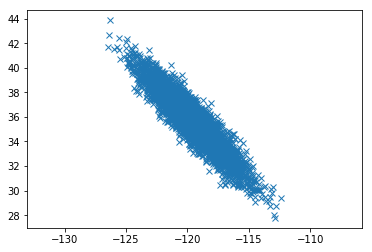

In [10]:
import matplotlib.pyplot as plt
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

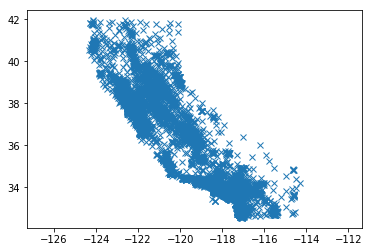

In [11]:
plt.plot(data["longitude"], data["latitude"], 'x')
plt.axis('equal')
plt.show()

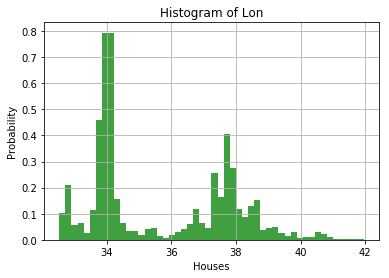

In [14]:
n, bins, patches = plt.hist(data["latitude"], 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Houses')
plt.ylabel('Probability')
plt.title('Histogram of Lon')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

In [ ]:
train_x = np.asarray(data[["longitude","latitude"]])
train_y = np.asarray(data[["housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"]])

In [ ]:
from sklearn import preprocessing
train_x = train_x / 100
train_y = preprocessing.MinMaxScaler().fit_transform(train_y)

In [ ]:
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float()

In [ ]:
#train_x = torch.tensor(data[["longitude","latitude"]].values).float()
#train_y = torch.tensor(data[["housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"]].values).float()

In [ ]:
train_y.shape

In [ ]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=7
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dim=2,has_lengthscale=True), grid_size=grid_size, num_dims=2,
            ), num_tasks=7, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [ ]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

In [ ]:
train_y[-1:,:]

In [ ]:
train_x[-1:,:]

In [ ]:
#mll.likelihood(output).log_prob(train_y).size()

In [ ]:
# Set into eval mode
model.eval()
likelihood.eval()

In [ ]:
# Make predictions
with torch.no_grad(), gpytorch.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(train_x))
    # Get mean
    mean = observed_pred.mean
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()

In [ ]:
mean

In [ ]:
mean[:1,:]

In [ ]:
train_y[:1,:]

In [ ]:
list(data[["housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"]])

In [ ]:
np.log10(710414720)